Model Rankings by Different Unified Metrics:
                        Model  Pearson  Binary_Accuracy  Unified_Equal  \
1    gemini-2.5-flash-preview   0.4427           0.8300       1.060341   
2                    qwen3-8b   0.4459           0.8161       0.976054   
3                 gpt-4o-mini   0.4243           0.8167       0.761410   
6           claude-3.7-sonnet   0.3898           0.8367       0.578627   
0       qwen-2.5-72b-instruct   0.4595           0.7400       0.474734   
7               qwen3-30b-a3b   0.3807           0.8267       0.402021   
13               gpt-4.1-nano   0.3422           0.8600       0.290345   
10           llama-4-maverick   0.3587           0.8233       0.149687   
5       deepseek-chat-v3-0324   0.4035           0.7500      -0.010773   
4                   qwen3-32b   0.4262           0.7133      -0.088372   
8              gemma-3-27b-it   0.3762           0.7600      -0.204380   
9                       phi-4   0.3675           0.7700      -0.208

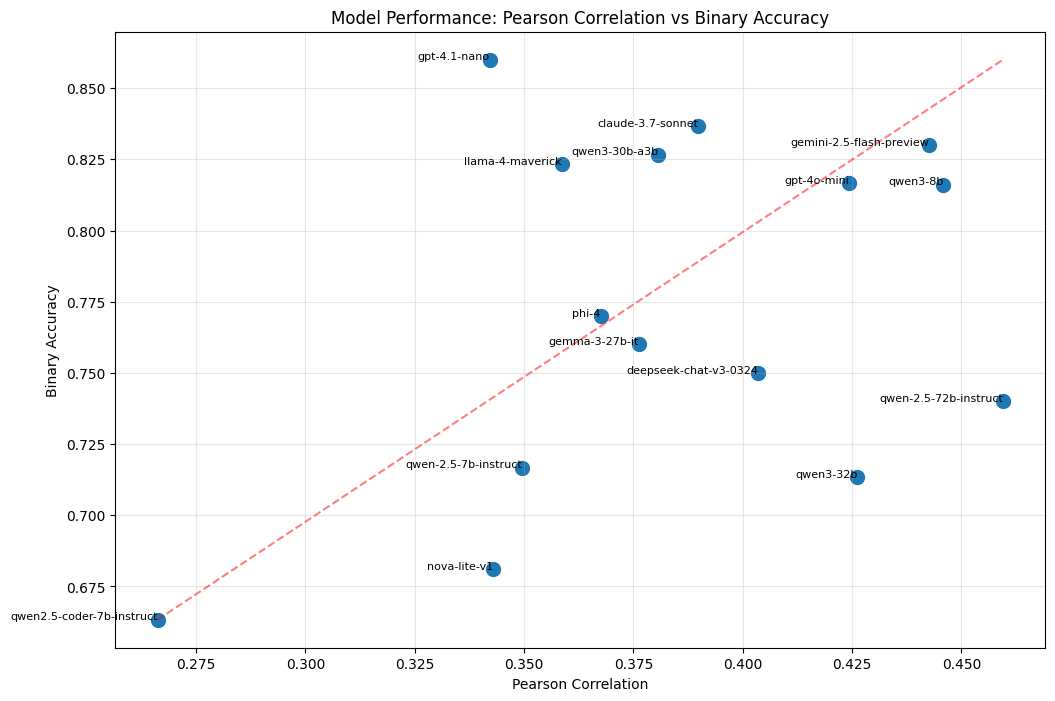

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Create dataframe with the model evaluation results
data = {
    'Model': [
        'qwen-2.5-72b-instruct', 'gemini-2.5-flash-preview', 'qwen3-8b', 
        'gpt-4o-mini', 'qwen3-32b', 'deepseek-chat-v3-0324', 
        'claude-3.7-sonnet', 'qwen3-30b-a3b', 'gemma-3-27b-it', 
        'phi-4', 'llama-4-maverick', 'qwen-2.5-7b-instruct', 
        'nova-lite-v1', 'gpt-4.1-nano', 'qwen2.5-coder-7b-instruct'
    ],
    'Pearson': [
        0.4595, 0.4427, 0.4459, 0.4243, 0.4262, 0.4035, 
        0.3898, 0.3807, 0.3762, 0.3675, 0.3587, 0.3496, 
        0.3430, 0.3422, 0.2662
    ],
    'Binary_Accuracy': [
        0.7400, 0.8300, 0.8161, 0.8167, 0.7133, 0.7500, 
        0.8367, 0.8267, 0.7600, 0.7700, 0.8233, 0.7167, 
        0.6810, 0.8600, 0.6633
    ]
}

df = pd.DataFrame(data)

# Calculate z-scores to normalize both metrics
df['Pearson_Z'] = zscore(df['Pearson'])
df['Binary_Z'] = zscore(df['Binary_Accuracy'])

# Create different weightings of the unified score
# Equal weights
df['Unified_Equal'] = (df['Pearson_Z'] + df['Binary_Z']) / 2

# Pearson-biased (60-40)
df['Unified_Pearson_Bias'] = 0.6 * df['Pearson_Z'] + 0.4 * df['Binary_Z']

# Binary-biased (40-60)
df['Unified_Binary_Bias'] = 0.4 * df['Pearson_Z'] + 0.6 * df['Binary_Z']

# Harmonic mean (favors balanced performance)
df['Unified_Harmonic'] = 2 / (1/df['Pearson_Z'] + 1/df['Binary_Z'])
df['Unified_Harmonic'] = df['Unified_Harmonic'].fillna(-3)  # Handle cases where z-scores are negative

# Create a product-based score (severely penalizes weakness in either metric)
df['Pearson_Scaled'] = (df['Pearson'] - df['Pearson'].min()) / (df['Pearson'].max() - df['Pearson'].min())
df['Binary_Scaled'] = (df['Binary_Accuracy'] - df['Binary_Accuracy'].min()) / (df['Binary_Accuracy'].max() - df['Binary_Accuracy'].min())
df['Unified_Product'] = df['Pearson_Scaled'] * df['Binary_Scaled']

# Create rankings for each unified metric
for col in ['Unified_Equal', 'Unified_Pearson_Bias', 'Unified_Binary_Bias', 'Unified_Product']:
    df[f'{col}_Rank'] = df[col].rank(ascending=False)

# Sort by the equal-weight unified score for default ranking
ranked_df = df.sort_values('Unified_Equal', ascending=False)

# Print the rankings
print("Model Rankings by Different Unified Metrics:")
print(ranked_df[['Model', 'Pearson', 'Binary_Accuracy', 'Unified_Equal', 'Unified_Product']].head(15))

# Visualization of models in 2D space
plt.figure(figsize=(12, 8))
plt.scatter(df['Pearson'], df['Binary_Accuracy'], s=100)

# Add labels to each point
for i, model in enumerate(df['Model']):
    plt.annotate(model, (df['Pearson'].iloc[i], df['Binary_Accuracy'].iloc[i]), 
                 fontsize=8, ha='right')

plt.title('Model Performance: Pearson Correlation vs Binary Accuracy')
plt.xlabel('Pearson Correlation')
plt.ylabel('Binary Accuracy')
plt.grid(True, alpha=0.3)

# Add a diagonal line to show balanced performance
plt.plot([df['Pearson'].min(), df['Pearson'].max()], 
         [df['Binary_Accuracy'].min(), df['Binary_Accuracy'].max()], 
         'r--', alpha=0.5)

# Calculate the combined metric rankings
result_table = ranked_df[['Model', 'Pearson', 'Binary_Accuracy', 'Unified_Equal', 'Unified_Product']]
result_table = result_table.rename(columns={
    'Unified_Equal': 'Combined Score (Equal Weight)',
    'Unified_Product': 'Combined Score (Product)'
})

print("\nFinal Unified Rankings:")
print(result_table.to_string(index=False))